In [12]:
import habitat
import habitat.gym
import os
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import (
    MeasurementConfig,
    ThirdRGBSensorConfig,
)

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw
import clip
import numpy as np
import torch

os.chdir('/srv/flash1/pputta7/projects/lm-nav')
# Quiet the Habitat simulator logging
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"

In [33]:
config=habitat.get_config("config/imagenav_hm3d.yaml")
env = habitat.Env(config=config)
observations = env.reset()  # noqa: F841

2023-08-29 20:43:04,047 Initializing dataset PointNav-v1
2023-08-29 20:43:04,228 initializing sim Sim-v0
2023-08-29 20:43:05,164 Initializing task Nav-v0


In [3]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

def load_image(img: str):
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_source = img.convert("RGB")
    image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image, image_transformed

In [34]:
imgs = []

for i in range(25):
    observations = env.step({'action': 'turn_left', 'action_args': None})
    imgs.append(observations['rgb'])


In [37]:
import cv2

# Get the list of images
# Create the video writer
video_writer = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 24, (imgs[0].shape[1], imgs[0].shape[0]))

# Write the images to the video writer
for image in imgs:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    video_writer.write(image)

# Close the video writer
video_writer.release()


final text_encoder_type: bert-base-uncased


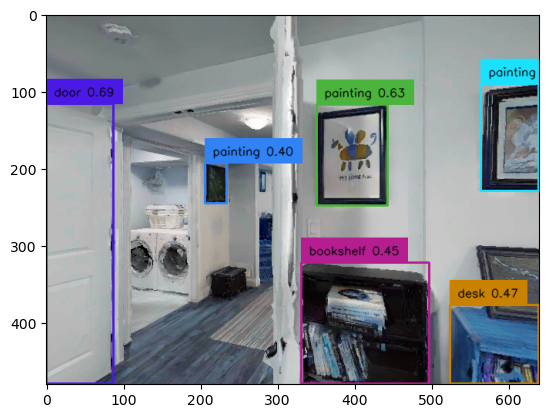

In [85]:
from groundingdino.util.inference import load_model, predict, annotate
import cv2

#observations = env.step({'action': 'turn_left', 'action_args': None})

model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "models/groundingdino_swint_ogc.pth")
TEXT_PROMPT = """\
door . guitar . chair. painting . drawer .\
desk . computer . window . mirror .\
treadmill . bookshelf . \
"""
BOX_TRESHOLD = 0.4
TEXT_TRESHOLD = 0.4

image_source, image = load_image(Image.fromarray(observations['rgb']))

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plt.imshow(annotated_frame)

In [4]:
from bliva.models import load_model_and_preprocess

model, vis_processors, _ = load_model_and_preprocess(name="bliva_vicuna", model_type="vicuna7b", is_eval=True, device='cuda')


100%|█████████████████████████████████████████████████████████████| 1.89G/1.89G [00:06<00:00, 306MB/s]
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.1.output_query.dense.bias', 'bert.encoder.layer.4.crossattention.self.key.bias', 'bert.encoder.layer.2.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.2.output_query.LayerNorm.weight', 'bert.encoder.layer.0.intermediate_query.dense.weight', 'bert.encoder.layer.9.output_query.dense.weight', 'bert.encoder.layer.8.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.3.output_query.dense.weight', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.output_query.dense.weight', 'bert.encoder.layer.7.output_query.LayerNorm.bias', 'bert.encoder.layer.2.crossattention.self.key.weight', 'bert.encoder.layer.4.intermediate_query.dense.weight', 'bert.encoder.layer.8.crossattention.self.key.weight', 'bert

HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: 'path to vicuna checkpoint'.

In [93]:
image = Image.fromarray(observations['rgb'])
# plt.imshow(image)
prompt = "How many cats: "
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Â?Â?Â?Â?Â?Â?Â?Â?Â?Â


In [92]:
generated_text

''